# Градиентный бустинг

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report, 
    confusion_matrix
)

sns.set_style("whitegrid")

# 1. Подготовить и проанализировать набор данных

In [47]:
file_name = 'Heart_Disease_and_Hospitals.csv'
df = pd.read_csv(file_name)

# 1. Определение признаков (X) и целевой переменной (y)
y = df['heart_disease']

# Удаляем целевую переменную и ненужные/идемнтифицирующие колонки
X = df.drop(['heart_disease', 'full_name', 'first_name', 'last_name', 'treatment_date','country'], axis=1)

# 2. Определение числовых и категориальных признаков
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(f"Числовые признаки: {list(numeric_features)}")
print(f"Категориальные признаки: {list(categorical_features)}")

# 3. Создание конвейера (Pipeline) для предобработки
# Для числовых признаков: StandardScaler (стандартизация)
numeric_transformer = StandardScaler()

# Для категориальных признаков: OneHotEncoder (кодирование)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Используем ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     # 20% данных в тест
    random_state=42,   # Для воспроизводимости
    stratify=y         # Сохраняем баланс классов
)

# 5. Применение предобработки
# Обучаем (fit) препроцессор на X_train и применяем (transform)
X_train_processed = preprocessor.fit_transform(X_train)

# Применяем (transform) тот же препроцессор к X_test
X_test_processed = preprocessor.transform(X_test)

Числовые признаки: ['age', 'blood_pressure', 'cholesterol', 'bmi', 'glucose_level']
Категориальные признаки: ['state', 'gender', 'hospital', 'treatment']


# 2, 3. Обучить модель и оценить качество  

In [48]:
start_time = time.time()
# Создаем модель с параметрами по умолчанию (random_state=42 для воспроизводимости)
gb_default = GradientBoostingClassifier(random_state=42)

# Обучение базовой модели
# Обучаем модель на предобработанных данных
gb_default.fit(X_train_processed, y_train)

# Делаем прогнозы на тестовой части
y_pred_default = gb_default.predict(X_test_processed)

# Оценка базовой модели
accuracy_default = accuracy_score(y_test, y_pred_default)
precision_default = precision_score(y_test, y_pred_default)
recall_default = recall_score(y_test, y_pred_default)
f1_default = f1_score(y_test, y_pred_default)

# Сохраняем метрики для итогового сравнения
metrics_summary = {
    'Default': {
        'Accuracy': accuracy_default,
        'Precision': precision_default,
        'Recall': recall_default,
        'F1-score': f1_default
    }
}

print(f"Accuracy (Точность): {accuracy_default:.4f}")
print(f"Precision (Точность класса 1): {precision_default:.4f}")
print(f"Recall (Полнота класса 1): {recall_default:.4f}")
print(f"F1-score (F1-мера класса 1): {f1_default:.4f}")

print("Отчет о классификации:")
print(classification_report(y_test, y_pred_default))

Accuracy (Точность): 0.9345
Precision (Точность класса 1): 0.9324
Recall (Полнота класса 1): 0.9371
F1-score (F1-мера класса 1): 0.9347
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       999
           1       0.93      0.94      0.93      1001

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



# 4. Визуализация матрицы ошибок

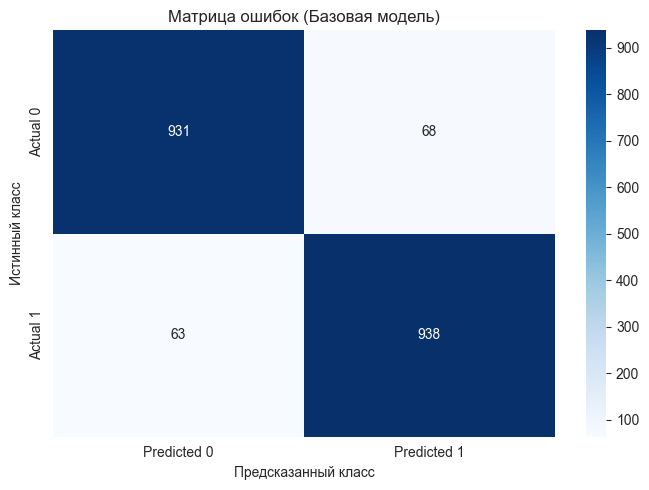

In [49]:
# Функция для отрисовки матрицы ошибок
def plot_confusion_matrix(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(title)
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.tight_layout()
    plt.savefig(filename) # Сохраняем график
    plt.show() # Показываем график в ноутбуке

# Отрисовка матрицы для базовой модели
plot_confusion_matrix(y_test, y_pred_default, 'Матрица ошибок (Базовая модель)', 'confusion_matrix_default.png')

# 5, 6. Подбор гиперпараметров

In [50]:
# Определяем сетку параметров для поиска
# Мы используем небольшой набор для демонстрации.
param_grid = {
    'n_estimators': [100, 200],       # Число деревьев
    'learning_rate': [0.1, 0.05],     # Скорость обучения
    'max_depth': [3, 5],              # Максимальная глубина дерева
    'subsample': [0.8, 1.0]           # Доля выборок для обучения (стохастический бустинг)
}

# Создаем модель
gb_model = GradientBoostingClassifier(random_state=42)

# Создаем объект GridSearchCV
grid_search = GridSearchCV(
    estimator=gb_model, 
    param_grid=param_grid, 
    cv=3,                # 3-кратная кросс-валидация
    scoring='f1',        # Оптимизируем по F1-мере
    n_jobs=-1,           # Используем все ядра
    verbose=1            # Показываем прогресс
)

start_time = time.time()
grid_search.fit(X_train_processed, y_train)

# Выводим лучшие параметры
print(f"Лучшие параметры, найденные GridSearchCV: {grid_search.best_params_}")
print(f"Лучший F1-score на кросс-валидации: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Лучшие параметры, найденные GridSearchCV: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Лучший F1-score на кросс-валидации: 0.9327


# 7. Оценка оптимизированной модели

Accuracy (Точность): 0.9400
Precision (Точность класса 1): 0.9340
Recall (Полнота класса 1): 0.9471
F1-score (F1-мера класса 1): 0.9405
Отчет о классификации (Оптимизированная модель):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       999
           1       0.93      0.95      0.94      1001

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



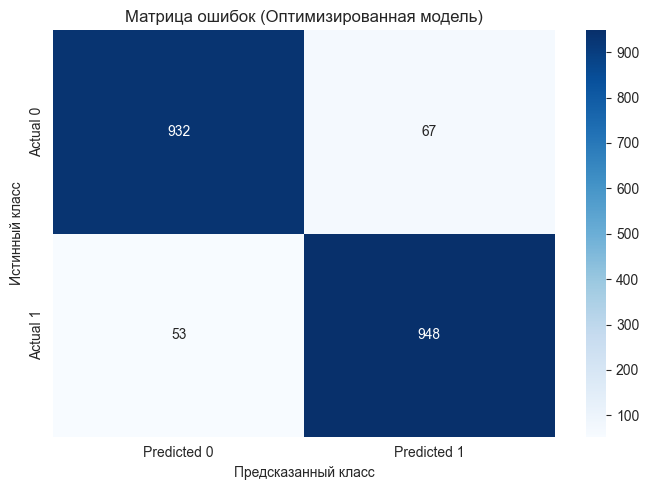

Сравнение базовой и оптимизированной модели
           Accuracy  Precision  Recall  F1-score
Default      0.9345     0.9324  0.9371    0.9347
Optimized    0.9400     0.9340  0.9471    0.9405


In [51]:
# Получаем лучшую модель, найденную GridSearchCV
best_model = grid_search.best_estimator_

# Делаем прогнозы на тестовой части
y_pred_best = best_model.predict(X_test_processed)

accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

# Сохраняем метрики для итогового сравнения
metrics_summary['Optimized'] = {
    'Accuracy': accuracy_best,
    'Precision': precision_best,
    'Recall': recall_best,
    'F1-score': f1_best
}

print(f"Accuracy (Точность): {accuracy_best:.4f}")
print(f"Precision (Точность класса 1): {precision_best:.4f}")
print(f"Recall (Полнота класса 1): {recall_best:.4f}")
print(f"F1-score (F1-мера класса 1): {f1_best:.4f}")

print("Отчет о классификации (Оптимизированная модель):")
print(classification_report(y_test, y_pred_best))

# Визуализация матрицы ошибок для лучшей модели
plot_confusion_matrix(y_test, y_pred_best, 'Матрица ошибок (Оптимизированная модель)', 'confusion_matrix_optimized.png')

# --- Сравнение моделей ---
print("Сравнение базовой и оптимизированной модели")
comparison_df = pd.DataFrame(metrics_summary).T
print(comparison_df.to_string(float_format="%.4f"))

# 8. Исследование гиперпараметров

Исследование (max_estimators=200, learning_rates=[0.01, 0.1, 0.5])
Используем max_depth=5, subsample=0.8


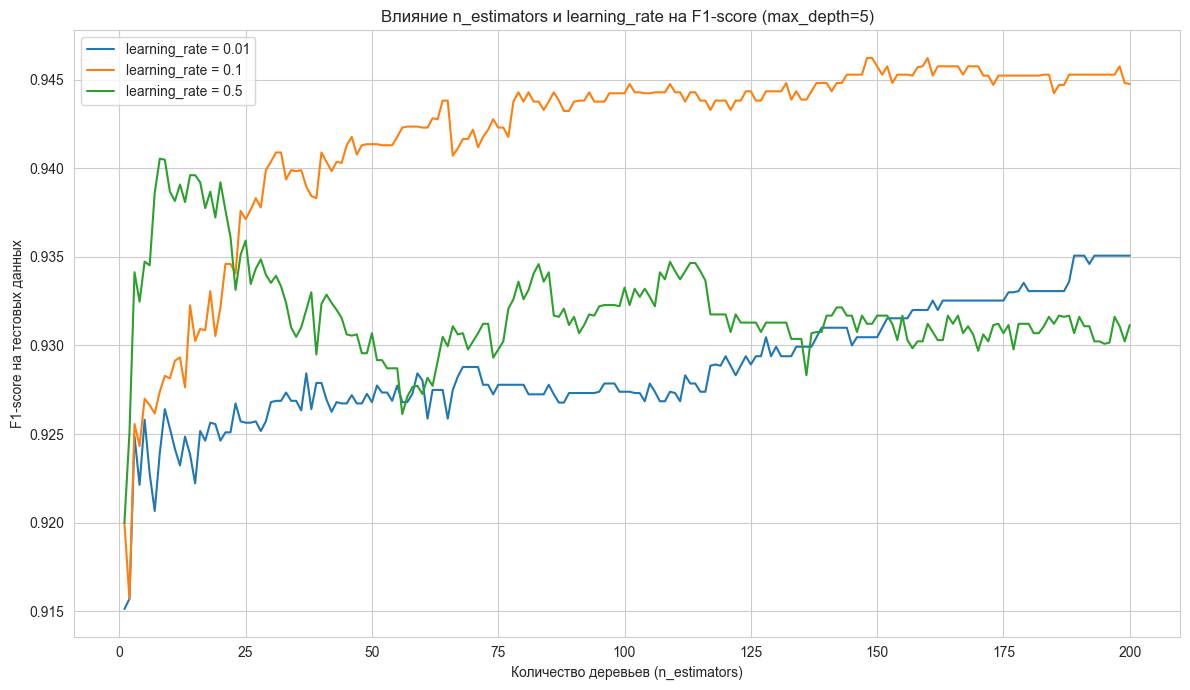

In [52]:
# Мы будем отслеживать F1-score на тестовых данных
# при разном количестве деревьев (n_estimators)
# для нескольких значений learning_rate

n_estimators_max = 200 # Максимальное количество деревьев для исследования
learning_rates = [0.01, 0.1, 0.5] # Значения learning_rate для проверки

# Используем лучшие параметры (кроме n_estimators и learning_rate) из GridSearchCV
best_depth = grid_search.best_params_['max_depth']
best_subsample = grid_search.best_params_['subsample']

print(f"Исследование (max_estimators={n_estimators_max}, learning_rates={learning_rates})")
print(f"Используем max_depth={best_depth}, subsample={best_subsample}")

results = {} # Словарь для хранения результатов

for lr in learning_rates:
    # Создаем модель
    model = GradientBoostingClassifier(
        n_estimators=n_estimators_max, 
        learning_rate=lr, 
        max_depth=best_depth, 
        subsample=best_subsample, 
        random_state=42
    )
    
    model.fit(X_train_processed, y_train)
    
    # Используем model.staged_predict() для получения прогнозов
    # на каждом этапе (после добавления каждого дерева)
    test_scores = []
    for y_pred_stage in model.staged_predict(X_test_processed):
        test_scores.append(f1_score(y_test, y_pred_stage))
    
    results[lr] = test_scores

# --- Визуализация результатов исследования ---
plt.figure(figsize=(12, 7))

for lr, scores in results.items():
    plt.plot(np.arange(1, n_estimators_max + 1), scores, label=f'learning_rate = {lr}')

plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('F1-score на тестовых данных')
plt.title(f'Влияние n_estimators и learning_rate на F1-score (max_depth={best_depth})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learning_rate_vs_n_estimators.png') # Сохраняем график
plt.show() # Показываем график в ноутбуке